In [24]:
import pandas as pd
import numpy as np

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [25]:
import sqlite3

connection=sqlite3.connect("../db.sqlite3")
cursor=connection.cursor()
sql_query = """
SELECT  order_id, datetime, product_id, quantity, name, price
FROM restaurant_order 
INNER JOIN restaurant_orderitem 
ON restaurant_order.id=restaurant_orderitem.order_id
INNER JOIN restaurant_product
ON restaurant_product.id=restaurant_orderitem.product_id
"""

data_=pd.read_sql(sql_query, connection)
data_.to_csv("data.csv", index=False)
cursor.close()
connection.close()
df=pd.read_csv("data.csv")
df

,order_id,datetime,product_id,quantity,name,price
0,1,2019-08-03 20:25:00,6,2,Plain Papadum,0.80
1,1,2019-08-03 20:25:00,240,1,King Prawn Balti,12.95
2,1,2019-08-03 20:25:00,19,1,Garlic Naan,2.95
3,1,2019-08-03 20:25:00,36,1,Mushroom Rice,3.95
4,1,2019-08-03 20:25:00,111,1,Paneer Tikka Masala,8.95
...,...,...,...,...,...,...
74813,3255,2016-05-18 18:53:00,247,2,House Red wine 75cl,17.95
74814,12905,2016-05-14 19:28:00,247,2,House Red wine 75cl,17.95
74815,3272,2016-05-10 13:18:00,247,2,House Red wine 75cl,17.95
74816,11404,2016-04-07 19:04:00,248,1,House white wine 75cl,17.95


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

<Axes: title={'center': 'Top 10 Most Popular Products by Quantity'}>

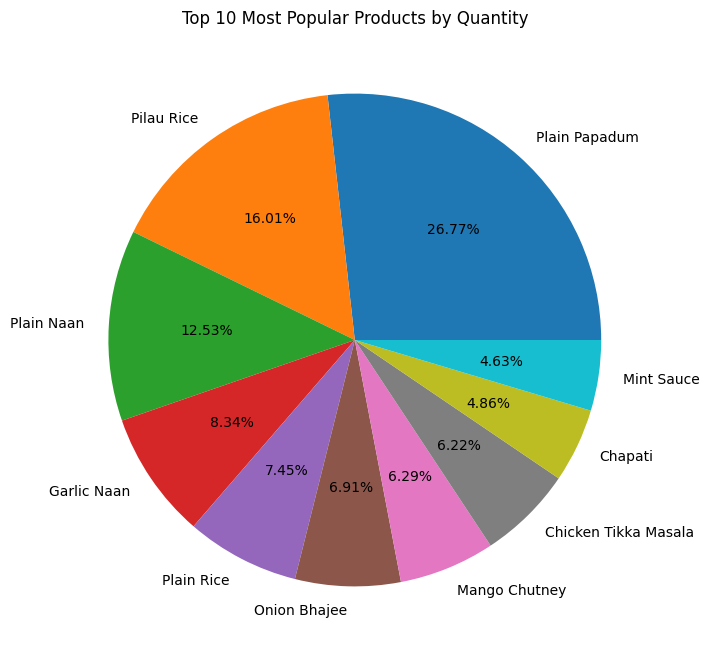

In [31]:
import matplotlib.pyplot as plt

top_products=df.groupby("name").sum("quantity").sort_values(by="quantity", ascending=False)[:10]
quantity=top_products["quantity"].sum()
top_products["percentage"]=(top_products["quantity"] * 100 / quantity).round(2)
top_products["percentage"].plot.pie(title="Top 10 Most Popular Products by Quantity", figsize=(8,8), autopct='%.2f%%', ylabel="")

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

<Axes: title={'center': 'Top 10 Products by Item Price'}>

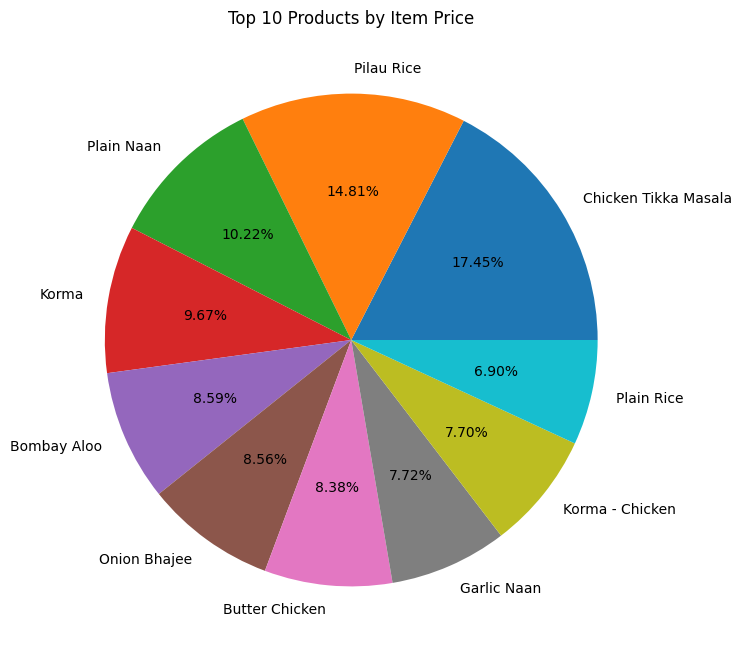

In [35]:
df["item_price"]=df["quantity"] * df["price"]
top_products_price=df.groupby("name").sum("item_price").sort_values(by="item_price", ascending=False)[:10]
top_products_price["item_price"].plot.pie(title="Top 10 Products by Item Price", figsize=(8,8), autopct='%.2f%%', ylabel="")

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

<Axes: xlabel='hour', ylabel='income'>

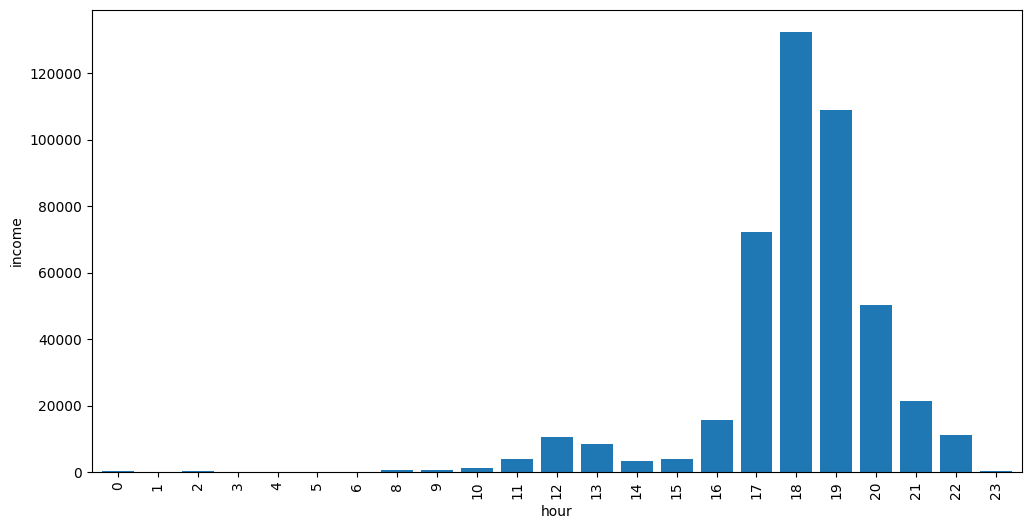

In [46]:
df["datetime"]=pd.to_datetime(df["datetime"])
df["hour"]=df["datetime"].dt.hour
data_hours= df.groupby("hour").sum("item_price").sort_values(by="hour")
data_hours.plot.bar(y="item_price", xlabel="hour", ylabel="income", width=0.8, figsize=(12, 6), legend=False)

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

<Axes: title={'center': 'Total Restaurant Income Based on Day Of The Week'}, xlabel='day_of_week', ylabel='income'>

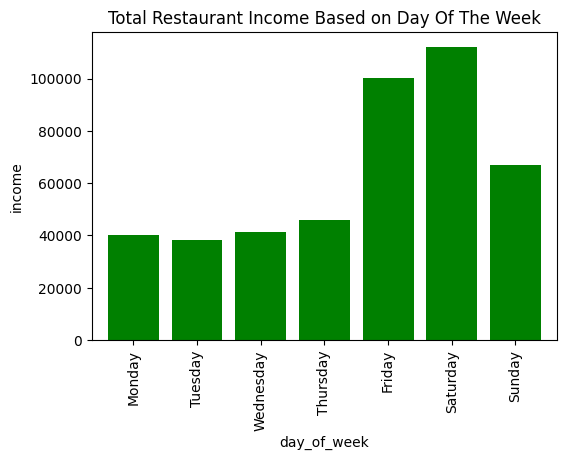

In [47]:
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["day_of_week"] = df["datetime"].dt.day_name()
df["day_of_week"] =pd.Categorical(df["day_of_week"], categories=days_of_week, ordered=True )
df = df.sort_values("day_of_week")
top_day = df.groupby("day_of_week", observed=False).sum("item_price")
top_day.plot.bar(y="item_price", xlabel="day_of_week", ylabel="income", color="g", width=0.8, figsize=(6, 4),title="Total Restaurant Income Based on Day Of The Week", legend=False)